In [295]:
import numpy as np
import pandas as pd
import sklearn
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt

In [256]:
df = pd.read_csv("SDSS-DR14.csv", sep=',', header=0)
df.head()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1.237650e+18,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752,301,4,267,3.722360e+18,STAR,-0.000009,3306,54922,491
1,1.237650e+18,183.598371,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752,301,4,267,3.638140e+17,STAR,-0.000055,323,51615,541
2,1.237650e+18,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752,301,4,268,3.232740e+17,GALAXY,0.123111,287,52023,513
3,1.237650e+18,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,752,301,4,269,3.722370e+18,STAR,-0.000111,3306,54922,510
4,1.237650e+18,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,752,301,4,269,3.722370e+18,STAR,0.000590,3306,54922,512


In [3]:
df.isnull().sum()

objid        0
ra           0
dec          0
u            0
g            0
r            0
i            0
z            0
run          0
rerun        0
camcol       0
field        0
specobjid    0
class        0
redshift     0
plate        0
mjd          0
fiberid      0
dtype: int64

In [4]:
df.groupby("class").count()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,redshift,plate,mjd,fiberid
class,,,,,,,,,,,,,,,,,
GALAXY,4998,4998,4998,4998,4998,4998,4998,4998,4998,4998,4998,4998,4998,4998,4998,4998,4998
QSO,850,850,850,850,850,850,850,850,850,850,850,850,850,850,850,850,850
STAR,4152,4152,4152,4152,4152,4152,4152,4152,4152,4152,4152,4152,4152,4152,4152,4152,4152


In [321]:
oversampler = RandomOverSampler(sampling_strategy={"GALAXY":4998, "QSO":4100, "STAR":4152 })
undersampler = RandomUnderSampler(sampling_strategy={"GALAXY":2998, "QSO":850, "STAR":2152 })


X = data.drop(["class"],axis=1).iloc[:,:17]
Y = data.iloc[:,13]

mask = [3, 4, 5, 6, 7, 13, 15]
X = X.iloc[:, mask]
display(X.columns)

X_over, Y_over = oversampler.fit_resample(X, Y)
X_under, Y_under = undersampler.fit_resample(X, Y)

Xo_train, Xo_test, Yo_train, Yo_test = train_test_split(X, Y, test_size = .3, random_state=25)
X_train, X_test, Y_train, Y_test = train_test_split(X_over, Y_over, test_size = .3, random_state=25)

scaler = preprocessing.StandardScaler().fit(X_train)
Xos_train = scaler.transform(Xo_train)
Xos_test = scaler.transform(Xo_test)
Xs_train = scaler.transform(X_train)
Xs_test = scaler.transform(X_test)

Index(['u', 'g', 'r', 'i', 'z', 'redshift', 'mjd'], dtype='object')

# Logistic Regression

In [324]:
print("Dataset original:")
LogReg = LogisticRegression(multi_class='ovr', max_iter=1000, solver="sag")
LogReg.fit(Xos_train, Yo_train)
Yo_pred = LogReg.predict(Xos_test)
confusion_matrix = metrics.confusion_matrix(Yo_test, Yo_pred)
display(confusion_matrix)
print(classification_report(Yo_test, Yo_pred))

print("Oversampling:")
LogReg = LogisticRegression(multi_class='ovr', max_iter=1000, solver="sag")
LogReg.fit(Xs_train, Y_train)
Y_pred = LogReg.predict(Xs_test)
confusion_matrix = metrics.confusion_matrix(Y_test, Y_pred)
display(confusion_matrix)
print(classification_report(Y_test, Y_pred))

display(LogReg.coef_)

Dataset original:


array([[1398,    3,   52],
       [  23,  224,    0],
       [  82,    0, 1218]], dtype=int64)

              precision    recall  f1-score   support

      GALAXY       0.93      0.96      0.95      1453
         QSO       0.99      0.91      0.95       247
        STAR       0.96      0.94      0.95      1300

    accuracy                           0.95      3000
   macro avg       0.96      0.94      0.95      3000
weighted avg       0.95      0.95      0.95      3000

Oversampling:


array([[1422,   11,   78],
       [  38, 1149,    0],
       [  67,    8, 1202]], dtype=int64)

              precision    recall  f1-score   support

      GALAXY       0.93      0.94      0.94      1511
         QSO       0.98      0.97      0.98      1187
        STAR       0.94      0.94      0.94      1277

    accuracy                           0.95      3975
   macro avg       0.95      0.95      0.95      3975
weighted avg       0.95      0.95      0.95      3975



array([[  1.60056331,  -1.90504372,   6.60009109,  -2.22633196,
         -5.22651789,  -1.62079564,  -2.10530272],
       [ -4.34502354,   8.15208262,   2.40174899,  -2.94311372,
         -3.20486707,   7.54419224,   0.04052461],
       [  1.79411842,  -5.5469007 ,  -3.58262813,   2.01475532,
          6.21464844, -18.55254688,   1.51064048]])

In [328]:
a = []
b = []
c = []
coef = [[ 0.00000000e+00,  1.14520463e-01,  1.98946846e-01,
         1.62023037e+00, -1.71659390e+00,  6.45187130e+00,
        -2.34158450e+00, -5.18750209e+00,  2.23166911e-01,
         0.00000000e+00, -6.36142111e-02, -1.44713714e-01,
        -1.71759772e-02, -1.78015460e+00, -1.71630345e-02,
        -2.21762464e+00,  3.54939217e-02],
       [ 0.00000000e+00, -1.18191374e-02,  9.51398386e-02,
        -4.42756699e+00,  7.95507502e+00,  2.15783900e+00,
        -2.47259898e+00, -3.14968731e+00, -4.03563369e-01,
         0.00000000e+00,  2.35817986e-01, -1.73732349e-01,
         5.82743745e-01,  7.91875172e+00,  5.82747874e-01,
        -1.17449039e+00, -9.71376859e-02],
       [ 0.00000000e+00, -9.44843341e-02, -2.73572760e-01,
         1.69421594e+00, -5.46005855e+00, -3.49100897e+00,
         1.93447213e+00,  6.23814468e+00, -9.58180685e-02,
         0.00000000e+00,  3.15797444e-02,  2.12247524e-01,
        -2.24104098e-01, -1.75863941e+01, -2.24115812e-01,
         2.04974949e+00, -1.35655141e-02]]

for i,x in enumerate(coef[0]):
    if abs(x) >= 1:
        a.append(i)
for i,x in enumerate(coef[1]):
    if abs(x) >= 1:
        b.append(i)
for i,x in enumerate(coef[2]):
    if abs(x) >= 1:
        c.append(i)
display(a, b, c)

[3, 4, 5, 6, 7, 13, 15]

[3, 4, 5, 6, 7, 13, 15]

[3, 4, 5, 6, 7, 13, 15]

Oversampling y undersampling mejoran algunas metricas pero empeoran otras.

# Decision Tree

In [329]:
dtree = tree.DecisionTreeClassifier()
dtree.fit(Xs_train, Y_train)

tree_pred = dtree.predict(Xs_test)
confusion_matrix = metrics.confusion_matrix(Y_test, tree_pred)
display(confusion_matrix)
print(classification_report(Y_test, tree_pred))

array([[1484,   21,    6],
       [   4, 1183,    0],
       [   0,    0, 1277]], dtype=int64)

              precision    recall  f1-score   support

      GALAXY       1.00      0.98      0.99      1511
         QSO       0.98      1.00      0.99      1187
        STAR       1.00      1.00      1.00      1277

    accuracy                           0.99      3975
   macro avg       0.99      0.99      0.99      3975
weighted avg       0.99      0.99      0.99      3975



In [ ]:
over y under lo mejoran

In [299]:
tree.plot_tree?

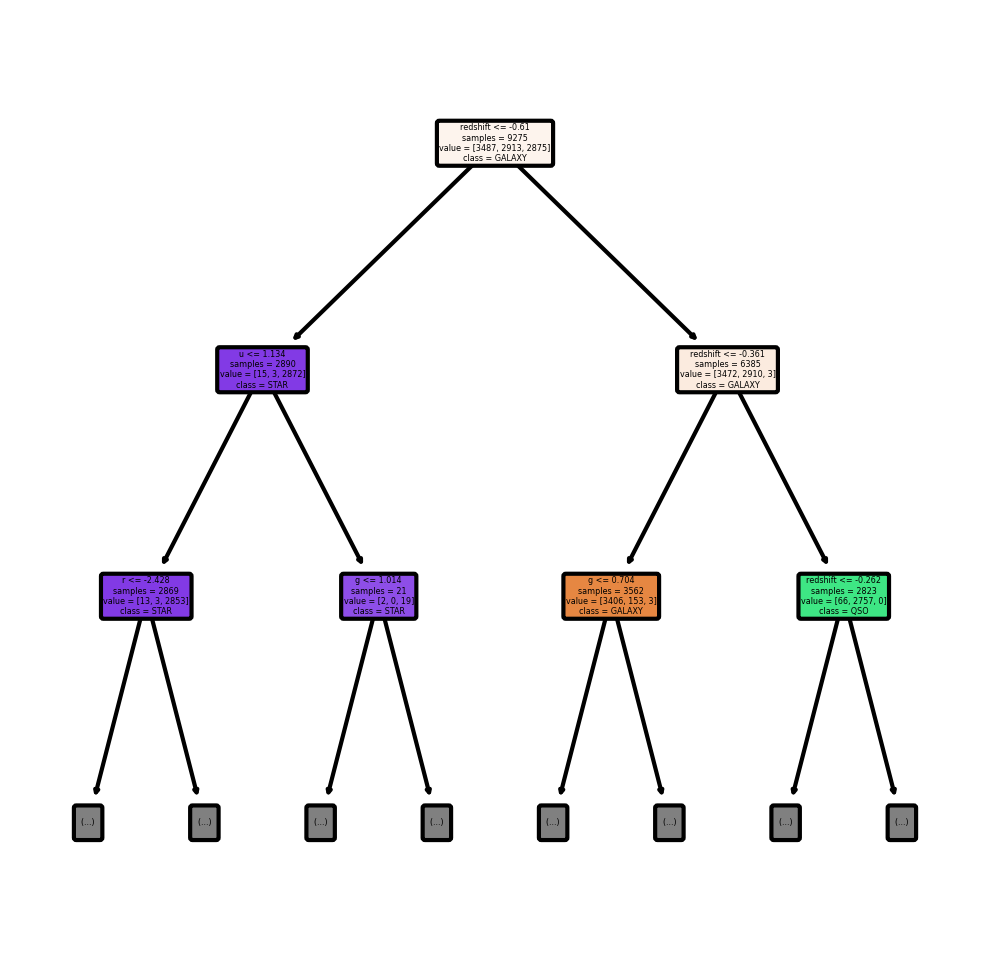

In [331]:
features=list(X.columns)
classes=["GALAXY", "QSO", "STAR"]

fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
tree.plot_tree(dtree, feature_names=features, class_names=classes, filled=True, 
                     rounded=True, impurity=False, max_depth=2);
fig.savefig('modelo.png')

# Random Forest

In [272]:
rforest = RandomForestClassifier(n_estimators=15)
rforest.fit(X_train, Y_train)

#Predicciones
forest_pred = rforest.predict(X_test)
#Evaluación del rendimiento del clasificador
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(Y_test, forest_pred)
print(confusion_matrix)
#Print de la matriz de confusión
from sklearn.metrics import classification_report
print(classification_report(Y_test, forest_pred))

[[1493    8   10]
 [   3 1184    0]
 [   1    0 1276]]
              precision    recall  f1-score   support

      GALAXY       1.00      0.99      0.99      1511
         QSO       0.99      1.00      1.00      1187
        STAR       0.99      1.00      1.00      1277

    accuracy                           0.99      3975
   macro avg       0.99      0.99      0.99      3975
weighted avg       0.99      0.99      0.99      3975



In [ ]:
over y under lo mejoran